<a href="https://colab.research.google.com/github/Kritika45678/Infosys-Training-Project-2/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import numpy as np
import matplotlib.pyplot as plt
import os

# Check for GPU
print(f"TensorFlow Version: {tf.__version__}")
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)


TensorFlow Version: 2.19.0
GPU Available:  True


In [ ]:
# 1. Load the dataset
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# 2. Preprocessing
# Normalize images to range [-1, 1]
X_train = (X_train.astype('float32') - 127.5) / 127.5

# Reshape to (Batch_Size, Height, Width, Channels) -> (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)

# 3. Batch and Shuffle the data
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)

print(f"Training Data Shape: {X_train.shape}")

Training Data Shape: (60000, 28, 28, 1)


In [ ]:
def build_generator(latent_dim=100, num_classes=10):
    # -- Input 1: The Label --
    label_input = Input(shape=(1,), name='label_input')
    # Embed label into a vector of size 50
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    # Scale up to image dimensions (so we can flatten and reshape it later)
    nodes = 7 * 7
    label_dense = layers.Dense(nodes)(label_embedding)
    label_reshaped = layers.Reshape((7, 7, 1))(label_dense)

    # -- Input 2: The Noise --
    noise_input = Input(shape=(latent_dim,), name='noise_input')
    # Scale up to 128 feature maps of size 7x7
    noise_nodes = 128 * 7 * 7
    noise_dense = layers.Dense(noise_nodes)(noise_input)
    noise_reshaped = layers.Reshape((7, 7, 128))(noise_dense)

    # -- Merge --
    merge = layers.Concatenate()([noise_reshaped, label_reshaped])

    # -- Upsampling (Deconvolution) --
    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Output Layer: 28x28x1 image, Tanh activation [-1, 1]
    out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(x)

    model = models.Model([noise_input, label_input], out_layer, name="Generator")
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6272)      │    633,472 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    262,272 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28, 1) │      6,273 │ leaky_re_lu_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,169,336 (4.46 MB)

 Trainable params: 1,169,336 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_discriminator(in_shape=(28,28,1), num_classes=10):
    # -- Input 1: The Image --
    img_input = Input(shape=in_shape, name='image_input')

    # -- Input 2: The Label --
    label_input = Input(shape=(1,), name='label_input')
    # Embed label to 28x28x1 to match image shape
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_dense = layers.Dense(28 * 28)(label_embedding)
    label_reshaped = layers.Reshape((28, 28, 1))(label_dense)

    # -- Merge Image and Label --
    merge = layers.Concatenate()([img_input, label_reshaped])

    # -- Downsampling (Convolution) --
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)

    # Output Layer: Single value (Real/Fake)
    out_layer = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model([img_input, label_input], out_layer, name="Discriminator")
    # Compile here because we train the discriminator separately
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 784)    │     39,984 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      2,432 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 7, 7, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 6272)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      6,273 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 196,773 (768.64 KB)

 Trainable params: 196,773 (768.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_cgan(g_model, d_model):
    # Freeze discriminator weights during generator training
    d_model.trainable = False

    # Get Generator inputs
    gen_noise, gen_label = g_model.input
    # Get Generator output
    gen_output = g_model.output

    # Feed Generator output + Label into Discriminator
    gan_output = d_model([gen_output, gen_label])

    model = models.Model([gen_noise, gen_label], gan_output, name="CGAN")
    opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

cgan = build_cgan(generator, discriminator)
cgan.summary()

Model: "CGAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6272)      │    633,472 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 128) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 129) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    264,320 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 14, 14,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    262,272 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28, 1) │      6,273 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Discriminator       │ (None, 1)         │    196,773 │ conv2d[0][0],     │
│ (Functional)        │                   │            │ label_input[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,366,109 (5.21 MB)

 Trainable params: 1,169,336 (4.46 MB)

 Non-trainable params: 196,773 (768.64 KB)

Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/30 [D loss: 1.0586, acc.: 8.35%] [G loss: 0.3114]
Epoch 2/30 [D loss: 1.1227, acc.: 8.23%] [G loss: 0.2647]
Epoch 3/30 [D loss: 1.1475, acc.: 8.21%] [G loss: 0.2475]
Epoch 4/30 [D loss: 1.1613, acc.: 8.21%] [G loss: 0.2382]
Epoch 5/30 [D loss: 1.1704, acc.: 8.20%] [G loss: 0.2323]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


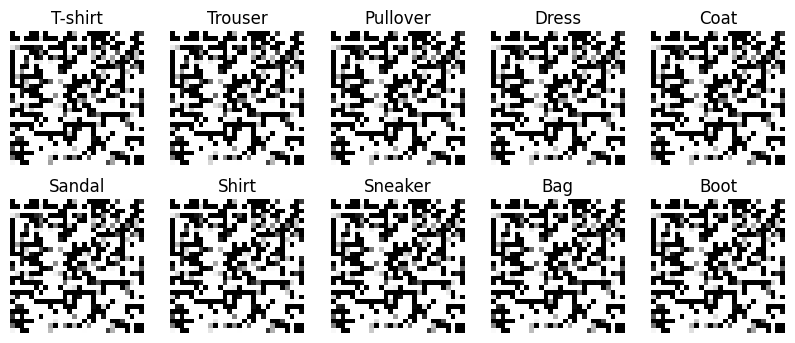

Epoch 6/30 [D loss: 1.1772, acc.: 8.19%] [G loss: 0.2280]
Epoch 7/30 [D loss: 1.1822, acc.: 8.18%] [G loss: 0.2249]
Epoch 8/30 [D loss: 1.1862, acc.: 8.20%] [G loss: 0.2224]
Epoch 9/30 [D loss: 1.1897, acc.: 8.20%] [G loss: 0.2203]
Epoch 10/30 [D loss: 1.1927, acc.: 8.20%] [G loss: 0.2186]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


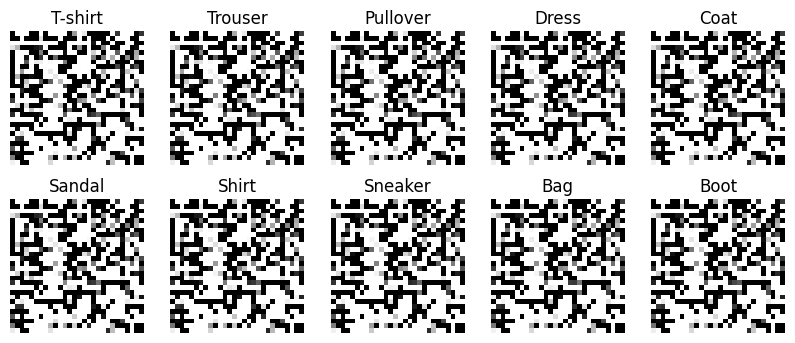

Epoch 11/30 [D loss: 1.1952, acc.: 8.19%] [G loss: 0.2171]
Epoch 12/30 [D loss: 1.1974, acc.: 8.19%] [G loss: 0.2158]
Epoch 13/30 [D loss: 1.1994, acc.: 8.18%] [G loss: 0.2147]
Epoch 14/30 [D loss: 1.2011, acc.: 8.18%] [G loss: 0.2137]
Epoch 15/30 [D loss: 1.2026, acc.: 8.18%] [G loss: 0.2128]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


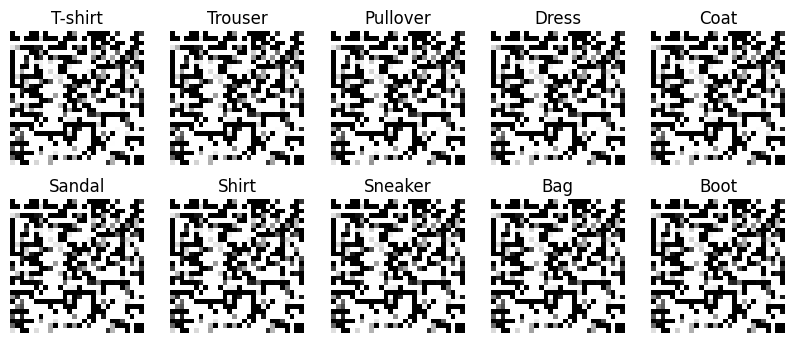

Epoch 16/30 [D loss: 1.2039, acc.: 8.18%] [G loss: 0.2121]
Epoch 17/30 [D loss: 1.2052, acc.: 8.18%] [G loss: 0.2114]
Epoch 18/30 [D loss: 1.2066, acc.: 8.17%] [G loss: 0.2106]
Epoch 19/30 [D loss: 1.2077, acc.: 8.17%] [G loss: 0.2100]
Epoch 20/30 [D loss: 1.2088, acc.: 8.17%] [G loss: 0.2094]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


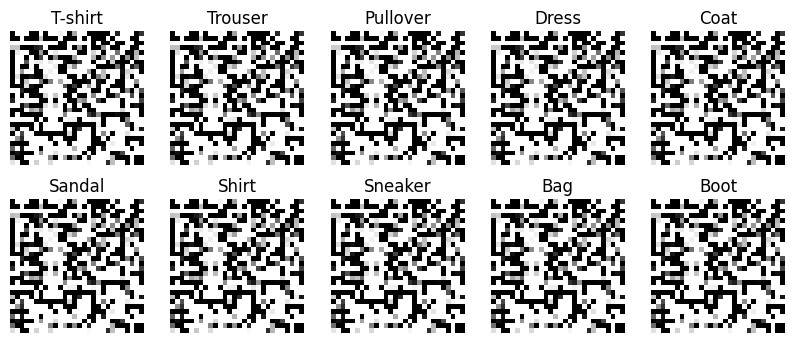

Epoch 21/30 [D loss: 1.2098, acc.: 8.17%] [G loss: 0.2089]
Epoch 22/30 [D loss: 1.2108, acc.: 8.17%] [G loss: 0.2084]
Epoch 23/30 [D loss: 1.2117, acc.: 8.16%] [G loss: 0.2079]
Epoch 24/30 [D loss: 1.2126, acc.: 8.16%] [G loss: 0.2074]
Epoch 25/30 [D loss: 1.2134, acc.: 8.16%] [G loss: 0.2070]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


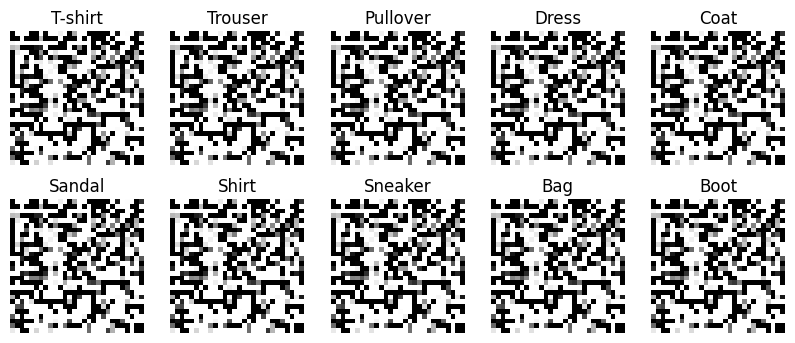

Epoch 26/30 [D loss: 1.2141, acc.: 8.17%] [G loss: 0.2066]
Epoch 27/30 [D loss: 1.2148, acc.: 8.16%] [G loss: 0.2062]
Epoch 28/30 [D loss: 1.2155, acc.: 8.16%] [G loss: 0.2059]
Epoch 29/30 [D loss: 1.2162, acc.: 8.16%] [G loss: 0.2055]
Epoch 30/30 [D loss: 1.2168, acc.: 8.16%] [G loss: 0.2052]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


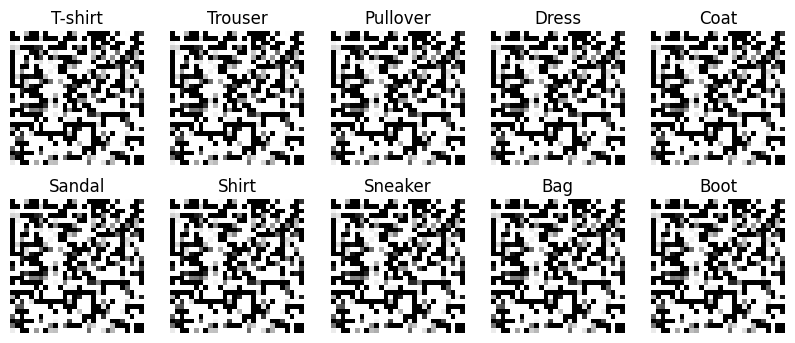

In [ ]:
# Helper to plot images during training
def sample_images(epoch, generator, latent_dim=100):
    r, c = 2, 5  # Grid size
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    labels = np.arange(0, 10).reshape(-1, 1) # Labels 0-9

    gen_imgs = generator.predict([noise, labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c, figsize=(10, 4))
    cnt = 0
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Boot']

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].set_title(class_names[cnt])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

# Training Parameters
epochs = 30  # Ideally 50+ for good results, 30 for a quick demo
latent_dim = 100

# Labels for real and fake data
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

print("Starting Training...")

for epoch in range(epochs):
    for i, (images, labels) in enumerate(dataset):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Get batch of real images
        current_batch_size = images.shape[0]
        real_labels = np.ones((current_batch_size, 1))
        fake_labels = np.zeros((current_batch_size, 1))

        # Generate fake images
        noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, (current_batch_size, 1))
        gen_imgs = generator.predict([noise, random_labels], verbose=0)

        # Train on Real
        d_loss_real = discriminator.train_on_batch([images, labels], real_labels)
        # Train on Fake
        d_loss_fake = discriminator.train_on_batch([gen_imgs, random_labels], fake_labels)

        # Average loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # We want the discriminator to think these samples are real (label=1)
        noise = np.random.normal(0, 1, (current_batch_size, latent_dim))
        sampled_labels = np.random.randint(0, 10, (current_batch_size, 1))

        # Train Generator (via CGAN model)
        g_loss = cgan.train_on_batch([noise, sampled_labels], real_labels)

    # Print progress
    print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

    # Show samples every 5 epochs
    if (epoch + 1) % 5 == 0:
        sample_images(epoch, generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


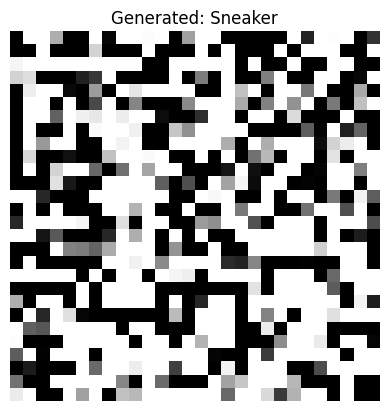

In [ ]:
# Generate a specific item (e.g., Ankle Boot = class 9)
def generate_specific_clothing(label_index):
    class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

    noise = np.random.normal(0, 1, (1, 100))
    label = np.array([[label_index]])

    prediction = generator.predict([noise, label])

    # Rescale to 0-1 for plotting
    img = 0.5 * prediction[0, :, :, 0] + 0.5

    plt.imshow(img, cmap='gray')
    plt.title(f"Generated: {class_names[label_index]}")
    plt.axis('off')
    plt.show()

# Try generating a Sneaker (Class 7)
generate_specific_clothing(7)